#  Random Forest Regression Pipeline

This notebook presents a step-by-step guide for building a **Random Forest Regressor** to predict `RANGE`, which likely represents a continuous distance measurement.

The pipeline includes:

1.  Loading and preparing the dataset
2.  Preprocessing features (scaling, splitting)
3.  Hyperparameter tuning using `RandomizedSearchCV`
4.  Model evaluation using MSE, RMSE, and R² score
5.  Analyzing feature importance and residuals
6.  Saving the model and scaler for future use


##  Load and Preview Dataset

We start by importing necessary libraries and reading the dataset using `pandas`.  
The shape of the dataset (rows × columns) is printed to verify successful loading and understand its size.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load and prepare data
data = pd.read_csv('../data/processed/aggregated_dataset.csv')
print("Dataset shape:", data.shape)

Dataset shape: (40798, 1029)


##  Define Features and Target

- `X` includes all input features **excluding** the `RANGE` (target) and `NLOS` (not needed for prediction).
- `y` is the target variable — `RANGE` — which we're aiming to predict.


In [3]:
# Separate features and target
X = data.drop(['RANGE', 'NLOS'], axis=1)  # Remove both RANGE and NLOS
y = data['RANGE']  # Target is RANGE

## Split and Scale the Data

- Split the dataset into **80% training** and **20% testing**.
- Apply `RobustScaler` to both training and test features.  
  This scaling method is **resistant to outliers**, ensuring robust normalization of features.

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Initialize Random Forest Model

We initialize a `RandomForestRegressor` with a fixed `random_state` to ensure reproducibility.  
This is the base estimator that will later be tuned using randomized search.


In [5]:
# Initialize base model
rf_reg = RandomForestRegressor(random_state=42)

## Hyperparameter Tuning using Randomized Search

We use `RandomizedSearchCV` to efficiently search across a subset of hyperparameter combinations:

- **`n_estimators`**: Number of trees in the forest  
- **`max_depth`**: Maximum depth of each tree  
- **`min_samples_split` / `min_samples_leaf`**: Controls tree complexity  
- **`max_features`**: Number of features to consider when splitting a node

**n_iter=1**: Only one random combination is tried (you can increase this for a full search).  
**cv=4**: 4-fold cross-validation ensures robust performance estimation.

In [6]:
# Random search for hyperparameter tuning
rf_random = RandomizedSearchCV(
    estimator=rf_reg,
    # Define hyperparameter search space
    param_distributions={
        'n_estimators': [200],
        'max_depth': [25],
        'min_samples_split': [5],
        'min_samples_leaf': [4],
        'max_features': ['sqrt']
    },
    n_iter=1,
    cv=4,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=2
)

##  Train the Model

Fit the model on the training set using the defined randomized hyperparameter space.  
During this process, cross-validation is performed to select the best-performing configuration.


In [7]:
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

# Print best parameters and score
print("\nBest parameters:", rf_random.best_params_)
print("Best MSE score:", -rf_random.best_score_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 25}
Best MSE score: 2.2346559506649575


##  Extract the Best Estimator

Retrieve the best-performing model (based on cross-validated MSE) from the `RandomizedSearchCV` object.


In [8]:
# Get the best model
best_rf_reg = rf_random.best_estimator_

# Make predictions
y_pred = best_rf_reg.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Test Set Performance:
Mean Squared Error: 2.1462
Root Mean Squared Error: 1.4650
R² Score: 0.6062


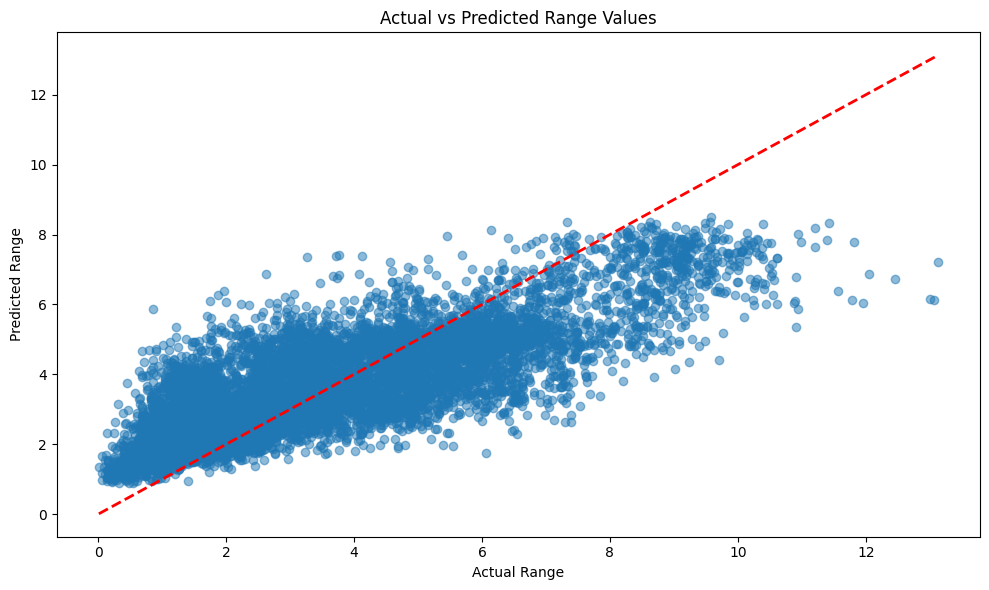

In [9]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.title('Actual vs Predicted Range Values')
plt.tight_layout()
plt.show()

## Top 20 Most Important Features

Visualize the top 20 features that contribute the most to prediction decisions.  
This helps in **interpreting the model** and potentially reducing dimensionality in future iterations.

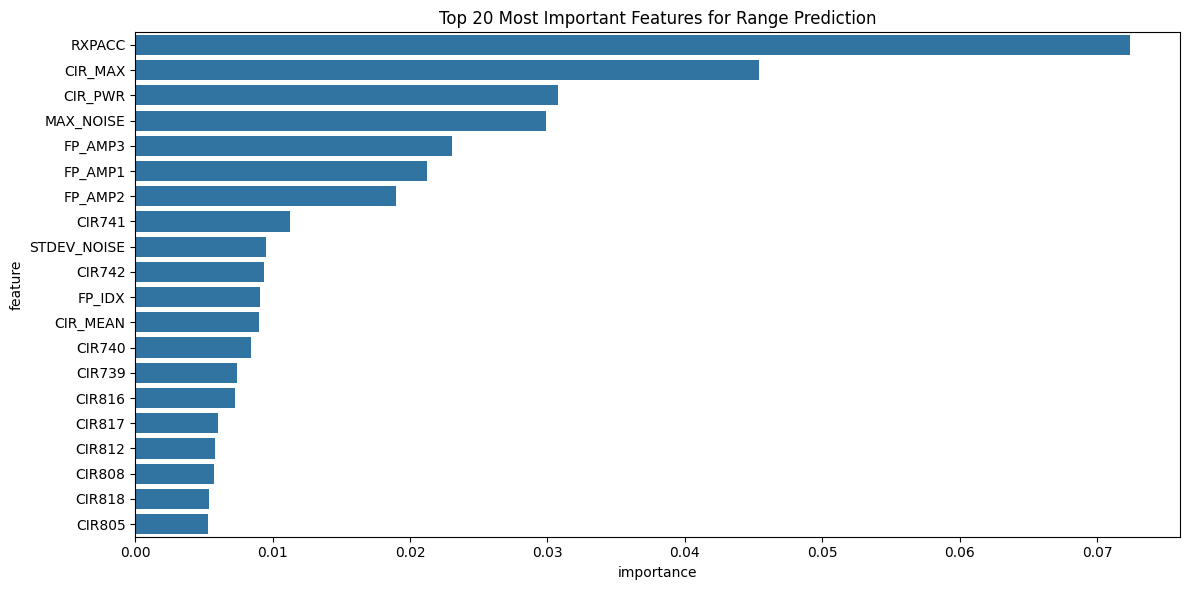

In [10]:
# Plot feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_reg.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Most Important Features for Range Prediction')
plt.tight_layout()
plt.show()

##  Save the Trained Model and Scaler

Use `joblib` to save both the trained random forest model and the feature scaler.  
This allows for fast loading and reuse of the model in future applications or production environments.


In [11]:
# Save the model and scaler
joblib.dump(best_rf_reg, '../models/best_rf_regressor.joblib')
joblib.dump(scaler, '../models/rf_regressor_scaler.joblib')

['../models/rf_regressor_scaler.joblib']

## Residual Analysis – Scatter Plot

Plot residuals (actual - predicted) against predicted values to check for:

- Bias (non-zero center)
- Heteroscedasticity (fan-shape spread)
- Patterns (non-random errors)

Ideally, residuals should be **randomly scattered around zero**.

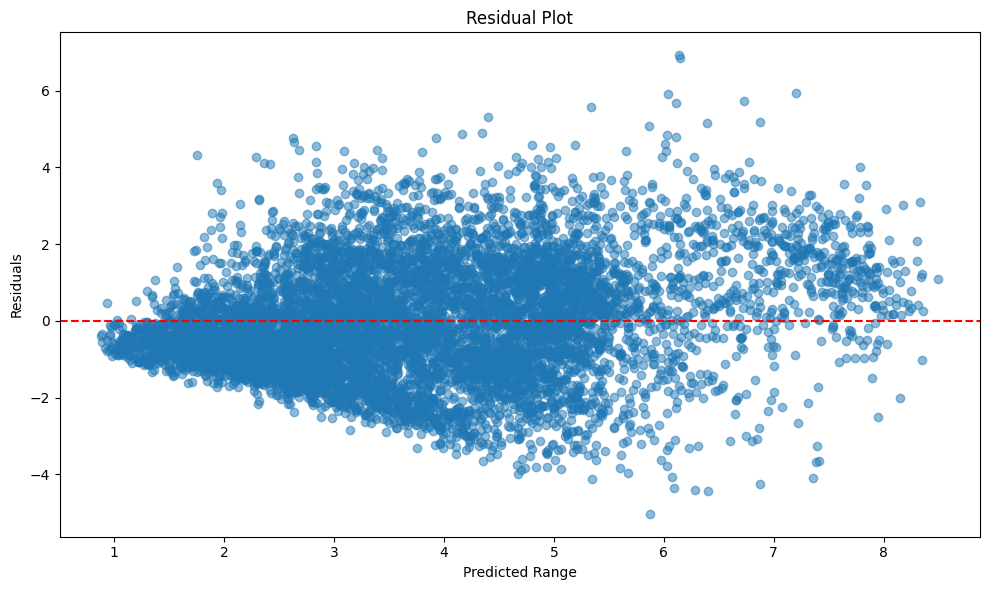

In [12]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Range')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

###  Residual Distribution

Histogram of residuals helps understand how errors are distributed.  
A roughly normal distribution centered at zero indicates a well-behaved model.


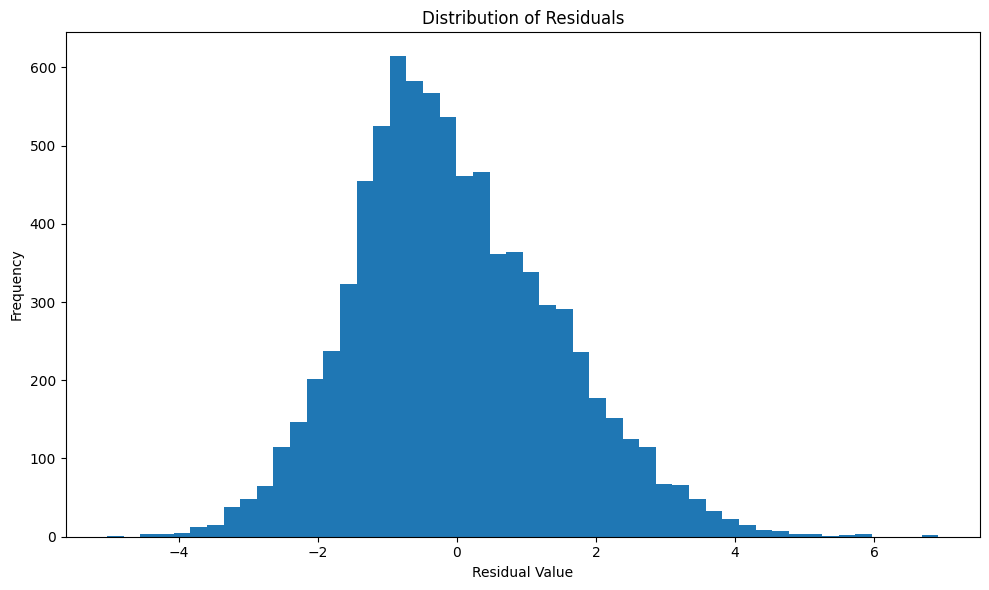

In [13]:
# Plot residuals distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

###  Residual Summary Statistics

Displays statistical summary (mean, std, quartiles) of the residuals to provide numerical insight into model error characteristics.


In [14]:
# Print summary statistics of residuals
print("\nResiduals Summary Statistics:")
print(pd.Series(residuals).describe())


Residuals Summary Statistics:
count    8160.000000
mean       -0.025507
std         1.464861
min        -5.028549
25%        -1.028420
50%        -0.194460
75%         0.928999
max         6.923091
Name: RANGE, dtype: float64
